In [1]:
!pip install segmentation-models --quiet

In [2]:
import cv2
import json
import seaborn as sns
from tqdm import tqdm_notebook
import albumentations as albu
import os
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models as sm

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Segmentation Models: using `keras` framework.


In [3]:
import pdb


In [4]:
data_dir = '../input/understanding_cloud_organization/'

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=f'{data_dir}train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=42, shuffle=True,threshold = 0.5, min_mask = 3500):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.pp = False
        # if mode == 'mask_pred':
        # self.pp = True
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.threshold = threshold
        self.min_mask = min_mask
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        elif self.mode == 'mask':
            return self.__generate_y(list_IDs_batch)
        elif self.mode == 'mask_pred':
            return X, self.__generate_y(list_IDs_batch)
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

In [6]:
train_df = pd.read_csv(f'{data_dir}train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
_, val_idx = train_test_split(mask_count_df.index, test_size=0.2, random_state=42)

def createVal(val_idx):
    val_generator = DataGenerator(
        val_idx, 
        df=mask_count_df,
        target_df=train_df,
        batch_size=16, 
        shuffle=False,
        reshape=(320, 480),
        mode='mask_pred',
        augment=False,
        n_channels=3,
        n_classes=4,
    )

    return val_generator

In [7]:
def post_process(probability, threshold, min_size):

    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    predictions = np.zeros(probability.shape, np.float32)
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))

    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1

    return predictions

In [8]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img, best_threshold, min_size):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    img = post_process(img, best_threshold, min_size)
    #print(f'{t[1]} masks removed')
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    
    
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
               # if pp == True:
               #     reshaped_mask = post_process(reshaped_mask, threshold, min_size)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, threshold, size, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.float32)
        rle = mask2rle(mask, threshold, size)
        rles.append(rle)
        
    return rles

In [9]:
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return ((2. * intersection.sum())+1) / (img1.sum() + img2.sum() + 1)

In [10]:
# Initialize mode and load trained weights

model = sm.Unet("resnet34",  
                classes=4,
                input_shape=(320, 480, 3),
                activation='sigmoid')

model.load_weights('../input/resuweight/res32_unet_unfreeze.h5')

85524480/85521592 [==============================] - 3s 0us/step


In [11]:
val_generator = createVal(val_idx)
thresholds = np.arange(0.3, 0.8, 0.025)
min_masks = [10000, 11000, 12000,13000,14000, 15000, 16000, 17000, 18000, 20000]

all_dices = [(thres, mask, 0) for thres in thresholds for mask in min_masks]


for batch in tqdm_notebook(range(len(val_generator))):
    X,y = val_generator.__getitem__(batch)
    y_pred = model.predict(X)
    for thres_idx,threshold in enumerate(thresholds):
        for mask_idx, min_mask in enumerate(min_masks):
            for i in range(y_pred.shape[0]):
                for label in range(y_pred.shape[-1]):
                    tmp =  post_process(y_pred[i, :,:, label], threshold, min_mask)
                    score = dice(tmp, y[i,:,:,label])
                    idx = (thres_idx*len(min_masks))+mask_idx
                    all_dices[idx] = (threshold, min_mask, all_dices[idx][-1]+score)
                    

In [12]:
dices_df = pd.DataFrame(all_dices, columns=['threshold', 'size', 'dice'])
dices_df.sort_values('dice', ascending=False, inplace=True)

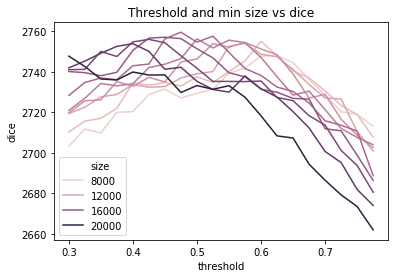

In [13]:
sns.lineplot(x='threshold', y='dice', hue='size', data=dices_df);
plt.title('Threshold and min size vs dice');

In [14]:
best_threshold = dices_df['threshold'].values[0]
best_size = dices_df['size'].values[0]

In [15]:
print(f"{best_threshold}, {best_size}")

0.47500000000000014, 15000


In [16]:
sample_submission_path = f'{data_dir}sample_submission.csv'
test_data_folder = f"{data_dir}test_images/"

In [17]:
sub_df= pd.read_csv(f'{data_dir}sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [18]:
test_dir = f'{data_dir}test_images'


In [19]:
test_df = []

for i in tqdm_notebook(range(0, test_imgs.shape[0], 500)):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(320, 480),
        n_channels=3,
        base_path=f'{data_dir}test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].astype(float)
#        for i in batch_pred_masks:
#            dice()
        pred_rles = build_rles(pred_masks, 0.5 , 15000,reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

198/198 [==============================] - 14s 71ms/step



In [20]:

test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('maskrem-unet.csv', index=False)



### Refrences:


* https://www.kaggle.com/amanooo/defect-detection-starter-u-net
* https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
